In [1]:
import hydra
import re
import pyrootutils
import os
import torch

from omegaconf import OmegaConf
import json
from typing import Optional
import transformers
from PIL import Image
from torchvision.transforms.functional import InterpolationMode

BOI_TOKEN = '<img>'
EOI_TOKEN = '</img>'
IMG_TOKEN = '<img_{:05d}>'

sep = "\n"
user_token = "USER"
assistant_token = "ASSISTANT"

IMG_FLAG = '<image>'
NUM_IMG_TOKNES = 32
NUM_IMG_CODES = 8192
image_id_shift = 32000

def generate(tokenizer, input_tokens, generation_config, model):
    """Only for batch_size=1"""

    input_ids = tokenizer(input_tokens, add_special_tokens=False, return_tensors='pt').input_ids
    input_ids = input_ids.to(model.device)

    generate_ids = model.generate(
        input_ids=input_ids,
        generation_config=generation_config
    )
    generate_ids = generate_ids[0][input_ids.shape[1]:]
    
    return generate_ids

def replace_img_tags(input_text):
    img_pattern = re.compile(r'<img>(.*?)</img>', re.IGNORECASE)
    img_matches = img_pattern.findall(input_text)
    
    for i, match in enumerate(img_matches):
        replacement = f'<IMAGE>'
        input_text = input_text.replace(f'<img>{match}</img>', replacement)
    
    return input_text

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append("/lid/home/saydalie/multimodal_cot/SEED/")

from models.seed_llama_tokenizer import SeedLlamaTokenizer
from models.transforms import get_transform
from models.model_tools import get_pretrained_llama_causal_model

# Load Tokenizer

In [ ]:
tokenizer_path = "/lid/home/saydalie/multimodal_cot/SEED/checkpoints/seed-tokenizer-2/"

tokenizer = SeedLlamaTokenizer.from_pretrained(
    pretrained_model_name_or_path=tokenizer_path,
    fp16=True,
    padding_side = 'left',
    load_diffusion=False,
    diffusion_path="stabilityai/stable-diffusion-2-1-unclip"
)

tokenizer.additional_special_tokens = []

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LlamaTokenizer'. 
The class this function is called from is 'SeedLlamaTokenizer'.
Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.e

missing keys:  511 unexpected keys: 146


# Load Dataset

In [4]:
import json

data_path = "/lid/home/saydalie/multimodal_cot/SEED/data/ReSQ/train_resq.json"
with open(data_path, "r") as file:
    data = json.load(file)['data']

In [5]:
prompt="""{bos}{user_token}: I now describe a scene and ask a question about it. First, think about the reasoning process using an interleaved combination of images and text. You should generate an image when necessary to support reasoning, then describe insights from the image. Finally, provide with the answer. The final answer is either one of {candidate_answers}. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process with images and text here </think> <answer> the final answer here </answer>.
{question}
{assistant_token}:"""

In [6]:
train_dataset = []

for d in data:
    story = d['story']
    questions = d['questions']
    
    for q in questions:
        question = q['question']
        answer = q['answer'][0]
        candidate_answers = q['candidate_answers']
        num_1st_context_sentences = q['num_1st_context_sentences']

        scene = ' '.join(story[:num_1st_context_sentences])
        train_dataset.append({
            'prompt': prompt.format(
                bos=tokenizer.bos_token,
                user_token=user_token,
                assistant_token=assistant_token,
                candidate_answers=candidate_answers,
                question=f"{scene} {question}"),
            'scene': scene,
            'answer': answer
        })

In [7]:
from datasets import Dataset

train_dataset = Dataset.from_list(train_dataset)
train_dataset = train_dataset.map(lambda sample: {'scene_ids': tokenizer.encode(sample['scene'])})
train_dataset

Map: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1008/1008 [00:00<00:00, 4181.15 examples/s]


Dataset({
    features: ['prompt', 'scene', 'answer', 'scene_ids'],
    num_rows: 1008
})

# Load the model

In [3]:
model_name_or_path="/lid/home/saydalie/multimodal_cot/SEED/checkpoints/seed-llama-8b-sft-comm"

model = get_pretrained_llama_causal_model(
    pretrained_model_name_or_path=model_name_or_path,
    torch_dtype="bf16",
    low_cpu_mem_usage=True
)

/home/saydalie/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:607: UserWarning: `pad_token_id` should be positive but got -1. This will cause errors when batch generating, if there is padding. Please set `pad_token_id` explicitly as `model.generation_config.pad_token_id=PAD_TOKEN_ID` to avoid errors in generation
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.77it/s]


In [9]:
# match the special tokens
model.config.eos_token_id = model.generation_config.eos_token_id = tokenizer.eos_token_id
model.config.bos_token_id = model.generation_config.bos_token_id = tokenizer.bos_token_id
model.config.pad_token_id = model.generation_config.pad_token_id = tokenizer.pad_token_id

In [32]:
import torch

# Define image token range
image_token_start = 300  # Example start index for image tokens
image_token_end = 400    # Example end index for image tokens

# Example labels tensor (some are image tokens, some are text tokens)
labels = torch.tensor([10, 50, 300, 305, 399, 401, 400, 250, 370])

# Apply masking
masked_labels = torch.where(
    torch.logical_and(labels >= image_token_start, labels <= image_token_end), 
    -100,  # Mask image tokens
    labels
)

# Print results
print("Original labels: ", labels.tolist())
print("Masked labels:   ", masked_labels.tolist())

Original labels:  [10, 50, 300, 305, 399, 401, 400, 250, 370]
Masked labels:    [10, 50, -100, -100, -100, 401, -100, 250, -100]


In [10]:
from peft import LoraConfig, get_peft_model

# modules_to_save=['embed_tokens', 'lm_head', 'input_layernorm', 'post_attention_layernorm', 'norm']
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    task_type='CAUSAL_LM',
    lora_dropout=0.05,
    target_modules=['q_proj', 'v_proj', 'k_proj', 'o_proj', 'gate_proj', 'down_proj', 'up_proj']
)

model = get_peft_model(model, lora_config)

model.print_trainable_parameters()

trainable params: 39,976,960 || all params: 6,845,517,824 || trainable%: 0.5840


# Reward Functions

In [21]:
import re
import json
import math

import torch
import torch.nn.functional as F

UTIL_CHECKPOINT_PATH = "/lid/home/saydalie/multimodal_cot/SEED/checkpoints/seed-utils/"

device = torch.device(f"cuda:{torch.cuda.current_device()}" if torch.cuda.is_available() else "cpu")

num_embeddings = 40194
embedding_dim = 4096
padding_idx=40193

embedding_layer = torch.nn.Embedding(num_embeddings, embedding_dim, padding_idx)
embedding_layer.load_state_dict(torch.load(UTIL_CHECKPOINT_PATH+"seed_llama_input_embeddings.pt"))
embedding_layer.to(device)

with open(UTIL_CHECKPOINT_PATH+"image_tokens_to_ids.json", "r") as f:
    image_tokens_to_ids = json.load(f)

def image_text_alignment_reward(completions, **kwargs):
    """Reward function for text and first image alignment using cosine similarity."""
    print("------------------- Reward -------------------")
    print(completions)
    scene_ids_batch = kwargs["scene_ids"]

    image_pattern = re.compile(r'<img>(.*?)</img>', re.IGNORECASE)
    rewards = []
    for completion, scene_ids in zip(completions, scene_ids_batch):
        image_matches = image_pattern.findall(completion)

        if image_matches:
            # keep only the first image
            image_tokens = image_matches[0].strip().split()
            image_ids = [image_tokens_to_ids[token] for token in image_tokens]
            image_ids = torch.tensor(image_ids).to(device)
            scene_ids = torch.tensor(scene_ids).to(device)
            with torch.no_grad():
                image_embeddings = embedding_layer(image_ids).mean(0).cpu()
                text_embeddings = embedding_layer(scene_ids).mean(0).cpu()
            # compute cosine similarity and rescale it to [0,1]
            cosine_sim = F.cosine_similarity(text_embeddings, image_embeddings, dim=0)
            cosine_sim = (cosine_sim + 1) / 2
            rewards.append(cosine_sim.item())
        else:
            rewards.append(0.0)
    print(rewards)
    print("--------------------------------------")
    return rewards

# test
completions = [
    '<think> <img> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_06429> <img_00680> </img> <think> <answer> the final answer here </answer>',
    '<think> <img> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_06429> <img_00680> </img> <img> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_06429> </img> <think> <answer> the final answer here </answer>',
    '<think> <img> <img_00680> <img_04340> <img_06229> <img_00680> <img_02143> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_06429> <img_00680> </img> <think> <answer> the final answer here </answer>',
    '<think> reasoning process with images and text here </think> <answer> the final answer '
]
scene_ids = [
    [1,  1023,  6282,  2879,  29892,  1716,  310,  963,  591,  4362,  1250,  4058,  29879,  29892,  526,  6493,  292,  263,  3762,  411,  3006,  23449,  2719,  29889], 
    [1,  1023,  6282,  2879,  29892,  1716,  310,  963,  591,  4362,  1250,  4058,  29879,  29892,  526,  6493,  292,  263,  3762,  411,  3006,  23449,  2719,  29889], 
    [1,  1023,  6282,  2879,  29892,  1716,  310,  963,  591,  4362,  1250,  4058,  29879,  29892,  526,  6493,  292,  263,  3762,  411,  3006,  23449,  2719,  29889], 
    [1,  1023,  6282,  2879,  29892,  1716,  310,  963,  591,  4362,  1250,  4058,  29879,  29892,  526,  6493,  292,  263,  3762,  411,  3006,  23449,  2719,  29889]
]
image_text_alignment_reward(completions=completions, scene_ids=scene_ids)

------------------- Reward -------------------
['<think> <img> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_06429> <img_00680> </img> <think> <answer> the final answer here </answer>', '<think> <img> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_06429> <img_00680> </img> <img> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680>

[0.5084418058395386, 0.5084418058395386, 0.5104049444198608, 0.0]

In [22]:
import math
import re

def image_count_reward(completions, **kwargs):
    """Reward function that checks the number of images."""
    image_pattern = re.compile(r'<img>(.*?)</img>', re.IGNORECASE)
    rewards = []
    for completion in completions:
        image_matches = image_pattern.findall(completion)
        image_nums = len(image_matches)

        if image_nums==0 or completion.count("<img>") != completion.count("</img>"):
            # no image or invalid image tokens
            rewards.append(0.0)
        elif image_nums==1:
            rewards.append(1.0)
        else:
            # exponential reward decay as number of images increases
            rewards.append(math.exp(-(image_nums - 1)))
    return rewards

# test
completions = [
    '<think> <img> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_06429> <img_00680> </img> <think> <answer> the final answer here </answer>',
    '<think> <img> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_06429> <img_00680> </img> <img> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_06429> </img> <think> <answer> the final answer here </answer>',
    '<think> <img> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <img_06429> <img_00680> </img> <think> <answer> the final answer here </answer>',
    '<think> <img_02123> <img_00680> <img_04240> <img_06429> <img_00680> <think> <answer> the final answer here </answer>',
    '<think> reasoning process with images and text here </think> <answer> the final answer '
]
image_count_reward(completions=completions)

[1.0, 0.36787944117144233, 1.0, 0.0, 0.0]

In [23]:
import re

def format_reward(completions, **kwargs):
    """Reward function that checks if the completion has a specific format."""
    pattern = r"^\s*<think>.*?</think>\s*<answer>.*?</answer>\s*$"
    matches = [re.match(pattern, completion) for completion in completions]
    return [1.0 if match else 0.0 for match in matches]

# test
completions = [
    '<think> reasoning process with images and text here </think> <answer> the final answer here </answer>', 
    '<think> reasoning process with images and text here </think> <answer> the final answer ',
    ' <think> The white thing behind the tree is a car. </think><answer> Yes. </answer> </s><s>',
    ' <think> The white thing behind the tree is a car. </think><answer> Yes. </answer>     '
]
format_reward(completions=completions)

[1.0, 0.0, 0.0, 1.0]

In [24]:
import re

def normalize_answer(answer):
    """Normalizes an answer by stripping whitespace, converting to lowercase, and removing punctuation."""
    return re.sub(r'[^a-zA-Z0-9]', '', answer).lower()
    
def accuracy_reward(completions, **kwargs):
    """Reward function that checks if the completion is the same as the ground truth."""
    answers = kwargs["answer"]
    rewards = []
    for completion, correct_answer in zip(completions, answers):
        match = re.search(r"<answer>(.*?)</answer>", completion, re.DOTALL)
        if match and normalize_answer(match.group(1)) == normalize_answer(correct_answer):
            rewards.append(1.0)
        else:
            rewards.append(0.0)
    return rewards

# test
completions = [
    '<think> reasoning process with images and text here </think> <answer>   yes. </answer>', 
    '<think> reasoning process with images and text here </think> <answer> Yes </answer>', 
    '<think> reasoning process with images and text here </think> <answer> the final answer '
]
answer = [
    'Yes', 
    'No',
    'No'
]
accuracy_reward(completions=completions, answer=answer)

[1.0, 0.0, 0.0]

# GRPO

In [25]:
from trl import GRPOConfig

# Configure training arguments using GRPOConfig
# asser (num_gpus * batch_size) % num_generations == 0
training_args = GRPOConfig(
    output_dir='test',
    num_train_epochs=10,
    learning_rate=5e-7,
    remove_unused_columns=False,
    eval_strategy="no",
    weight_decay=5e-2,
    warmup_ratio=0.01,
    lr_scheduler_type="cosine",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    torch_empty_cache_steps=1,
    gradient_checkpointing=False,
    dataloader_num_workers=4,
    bf16=True,
    fp16=False,
    adam_beta1=0.9,
    adam_beta2=0.95,
    adam_epsilon=1e-5,
    # deepspeed=DEEPSPEED_CONFIG,
    # # Inference Optimization - TODO: fix the vllm issues
    # use_vllm=True,
    # vllm_max_model_len=700,
    # vllm_device='auto',
    # vllm_dtype='auto',
    # Parameters that control the data preprocessing
    temperature=1.0,
    max_completion_length=700,
    num_generations=4,
    max_prompt_length=256,
    beta=0.04,
    # Parameters related to reporting and saving
    save_strategy="steps",
    save_steps=0.05,
    save_total_limit=2,
    logging_strategy='steps',
    logging_steps=1,
    log_level='warning',
    logging_nan_inf_filter="no",
    push_to_hub=False,
    report_to="none"
)

In [26]:
from trl import GRPOTrainer

trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=[image_text_alignment_reward],
    args=training_args,
    train_dataset=train_dataset
)

[2025-03-29 09:14:23,676] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


INFO 03-29 09:14:25 [__init__.py:239] Automatically detected platform cuda.


2025-03-29 09:14:25,181	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [17]:
# from trl import GRPOTrainer

# class GRPOTrainerCustom(GRPOTrainer):
#     def __init__(
#             self,
#             *args,
#             **kwargs
#         ):
#         super().__init__(*args, **kwargs)

# trainer = GRPOTrainerCustom(
#     model=model,
#     processing_class=tokenizer,
#     reward_funcs=[image_text_alignment_reward],
#     args=training_args,
#     train_dataset=train_dataset
# )

In [27]:
trainer.train()

------------------- Reward -------------------
['The boy is standing next to a black desk. <b>Is the black thing in front of the grey thing?</b> ', '(think) The dark-skinned, dark-haired boy in black pullover and blue pants is standing next to a desk grey brick walls and blue sky background. In an interleaved combination of images and text, we describe the image as a dark-skinned, dark-haired boy standing in the background next to a desk.  We can observe that the boy is wearing a black pullover and blue pants. We can also observe that he is wearing a black thing in front of him. The question asks: “ <img> <img_05054> <img_00680> <img_02648> <img_01608> <img_02157> <img_05692> <img_00200> <img_01966> <img_07379> <img_03449> <img_02157> <img_03704> <img_01608> <img_02345> <img_02648> <img_05642> <img_02157> <img_00441> <img_02157> <img_01966> <img_02728> <img_00202> <img_01878> <img_03449> <img_07100> <img_01542> <img_07100> <img_00441> <img_02648> <img_04588> <img_04186> <img_04400> </i

Step,Training Loss


------------------- Reward -------------------
['<think> Yes, the girl is wearing a pinkish (or light pink) pullover on top of her gray-haired t-shirt. She is at a desk in front of a building with many shining tinsels. </think><answer> Yes</answer>.', '<think><font=italic>What is it?></think><think>is it light blue?</think><think>is the building dark brown?</think><think>Is the brown building dark?</think><think>The pinkish greyish pullover has a brown back?</think><think>Is her pinkish greyish pullover on the wrong side?</think><think>Did she turn the pullover inside out?</think><think>A pinkish greyish pullover can be brown</think><think>Is the ground pinkish greyish instead of dark brown?</think><think>What kind of ground is it?</think> <img> <img_00592> <img_02157> <img_06583> <img_07463> <img_00680> <img_05794> <img_02984> <img_03123> <img_07463> <img_02315> <img_02157> <img_07463> <img_06583> <img_00706> <img_02822> <img_05436> <img_02157> <img_05794> <img_02157> <img_07463> <img

KeyboardInterrupt: 

# Generate

In [11]:
from transformers.generation.configuration_utils import GenerationConfig

generation_config = GenerationConfig(
    # temperature=1.0,
    # num_beams=1,
    max_new_tokens=10,
    # top_p=0.7,
    do_sample=False
)

In [12]:
prompt = """{bos}{user_token}: I now describe a scene and ask a question about it. First, generate an image for the described scene. Then, reason over the image to answer the question. Finally, provide with the final answer. The final answer is either one of [Yes, No]. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process with an image and text here </think> <answer> the final answer here </answer>.
{question}
{assistant_token}:"""
scene = "A white hostel with a large tree to its left and a gravel road in front of the wooden entrance."
question = "Is the white thing behind the tree?"

input_tokens = prompt.format(
    bos=tokenizer.bos_token,
    user_token=user_token,
    assistant_token=assistant_token,
    question=f"{scene} {question}"
)

print(input_tokens)

<s>USER: I now describe a scene and ask a question about it. First, generate an image for the described scene. Then, reason over the image to answer the question. Finally, provide with the final answer. The final answer is either one of [Yes, No]. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process with an image and text here </think> <answer> the final answer here </answer>.
A white hostel with a large tree to its left and a gravel road in front of the wooden entrance. Is the white thing behind the tree?
ASSISTANT:


In [13]:
device = 'cuda'
model.to(device)
print(model.device)

cuda:0


In [20]:
model.training

False

In [18]:
generate_ids = generate(tokenizer, input_tokens, generation_config, model)
generate_ids.shape

torch.Size([10])

### Decode

In [19]:
# decode text
output_text = tokenizer.batch_decode(generate_ids.unsqueeze(0), skip_special_tokens=True)
# output_text = replace_img_tags(output_text[0])
output_text

['<think> Yes, the white thing is']

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 22.74it/s]


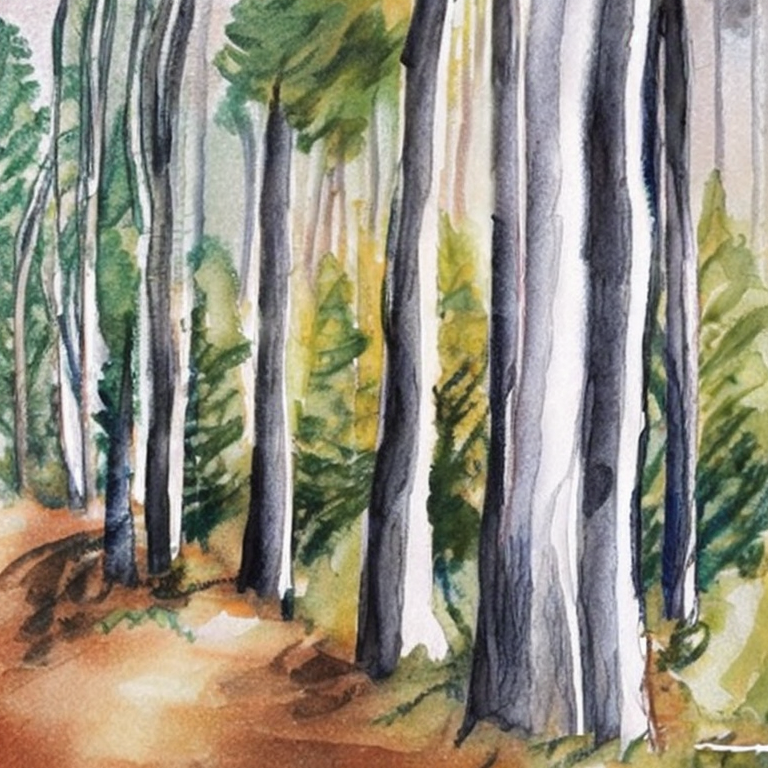

In [30]:
# decode images
boi_list = torch.where(generate_ids == tokenizer(BOI_TOKEN, add_special_tokens=False).input_ids[0])[0]
eoi_list = torch.where(generate_ids == tokenizer(EOI_TOKEN, add_special_tokens=False).input_ids[0])[0]

for boi_index, eoi_index in zip(boi_list, eoi_list):
    image_ids = (generate_ids[boi_index+1:eoi_index] - image_id_shift).reshape(1,-1)
    image = tokenizer.decode_image(image_ids)[0]
    image.show()

# Loss Function

In [5]:
model.to('cuda:0')
print(model.device)

cuda:0


In [6]:
from trl.trainer.utils import selective_log_softmax

def _get_per_token_logps(model, input_ids, attention_mask, logits_to_keep):
    # We add 1 to `logits_to_keep` because the last logits of the sequence is later excluded
    logits = model(input_ids=input_ids, attention_mask=attention_mask, logits_to_keep=logits_to_keep + 1).logits
    logits = logits[:, :-1, :]  # (B, L-1, V), exclude the last logit: it corresponds to the next token pred

    input_ids = input_ids[:, -logits_to_keep:]
    # For transformers<=4.48, logits_to_keep argument isn't supported, so here we drop logits ourselves.
    # See https://github.com/huggingface/trl/issues/2770
    logits = logits[:, -logits_to_keep:]
    return selective_log_softmax(logits, input_ids) 
    
def compute_loss(model, inputs, return_outputs=False, num_items_in_batch=None, beta=0.04):
    if return_outputs:
        raise ValueError("The GRPOTrainer does not support returning outputs")
    # Compute the per-token log probabilities for the model

    prompt_ids, prompt_mask = inputs["prompt_ids"], inputs["prompt_mask"]
    completion_ids, completion_mask = inputs["completion_ids"], inputs["completion_mask"]
    input_ids = torch.cat([prompt_ids, completion_ids], dim=1)
    attention_mask = torch.cat([prompt_mask, completion_mask], dim=1)
    logits_to_keep = completion_ids.size(1)  # we only need to compute the logits for the completion tokens

    per_token_logps = _get_per_token_logps(model, input_ids, attention_mask, logits_to_keep)

    # Compute the KL divergence between the model and the reference model
    ref_per_token_logps = inputs["ref_per_token_logps"]
    per_token_kl = torch.exp(ref_per_token_logps - per_token_logps) - (ref_per_token_logps - per_token_logps) - 1

    # x - x.detach() allows for preserving gradients from x
    advantages = inputs["advantages"]
    per_token_loss = torch.exp(per_token_logps - per_token_logps.detach()) * advantages.unsqueeze(1)
    per_token_loss = -(per_token_loss - beta * per_token_kl)

    # # seq_level_mean (trl): ensures each sequence contributes equally, regardless of length
    # loss = ((per_token_loss * completion_mask).sum(dim=1) / completion_mask.sum(dim=1)).mean()

    # token_level_mean: gives more weight to longer sequences
    loss = (per_token_loss * completion_mask).sum() / completion_mask.sum()

    """
    Example with 2 outputs:
    completion_length: [ 35, 467]
    losses: [seq_level_mean, token_level_mean]
    
    advantage: [0.0, 0.0]
    losses: [4.7022e-06, 3.3281e-06]
    
    advantage: [1.0, 0.0]
    losses: [-0.5000, -0.0697]
    
    advantage: [0.0, 1.0]
    losses: [-0.5000, -0.9303]
    
    advantage: [1.0, 1.0]
    losses: [-1.0000, -1.0000]
    """

    # # Log the metrics
    # completion_length = self.accelerator.gather_for_metrics(completion_mask.sum(1)).float().mean().item()
    # self._metrics["completion_length"].append(completion_length)

    # mean_kl = ((per_token_kl * completion_mask).sum(dim=1) / completion_mask.sum(dim=1)).mean()
    # self._metrics["kl"].append(self.accelerator.gather_for_metrics(mean_kl).mean().item())

    return loss

In [25]:
prompt_ids = torch.tensor([[    1,  3148,  1001, 29901,   306,  1286,  8453,   263,  9088,   322,
          2244,   263,  1139,  1048,   372, 29889,  3824, 29892,  5706,   385,
          1967,   363,   278,  5439,  9088, 29889,  1987, 29892,  2769,   975,
           278,  1967,   304,  1234,   278,  1139, 29889,  9788, 29892,  3867,
           411,   278,  2186,  1234, 29889,   450,  2186,  1234,   338,  2845,
           697,   310,  6024,  8241,   742,   525,  3782, 13359,   450, 24481,
          1889,   322,  1234,   526,   427, 15603,  2629,   529,   386,   682,
         29958,  1533,   386,   682, 29958,   322,   529, 12011, 29958,  1533,
         12011, 29958,  8282, 29892,  8307, 29892,   474, 29889, 29872,  1696,
           529,   386,   682, 29958, 24481,  1889,   411,   385,  1967,   322,
          1426,  1244,  1533,   386,   682, 29958,   529, 12011, 29958,   278,
          2186,  1234,  1244,  1533, 12011, 15513,    13,  8357,   272,  3304,
          1776,   310, 12955,   297,   997, 27437, 29889,  1317,   278,  3699,
           297,   425,   282,   834, 29973,    13, 22933,  9047, 13566, 29901],
        [    1,  3148,  1001, 29901,   306,  1286,  8453,   263,  9088,   322,
          2244,   263,  1139,  1048,   372, 29889,  3824, 29892,  5706,   385,
          1967,   363,   278,  5439,  9088, 29889,  1987, 29892,  2769,   975,
           278,  1967,   304,  1234,   278,  1139, 29889,  9788, 29892,  3867,
           411,   278,  2186,  1234, 29889,   450,  2186,  1234,   338,  2845,
           697,   310,  6024,  8241,   742,   525,  3782, 13359,   450, 24481,
          1889,   322,  1234,   526,   427, 15603,  2629,   529,   386,   682,
         29958,  1533,   386,   682, 29958,   322,   529, 12011, 29958,  1533,
         12011, 29958,  8282, 29892,  8307, 29892,   474, 29889, 29872,  1696,
           529,   386,   682, 29958, 24481,  1889,   411,   385,  1967,   322,
          1426,  1244,  1533,   386,   682, 29958,   529, 12011, 29958,   278,
          2186,  1234,  1244,  1533, 12011, 15513,    13,  8357,   272,  3304,
          1776,   310, 12955,   297,   997, 27437, 29889,  1317,   278,  3699,
           297,   425,   282,   834, 29973,    13, 22933,  9047, 13566, 29901]],
       device='cuda:0')
prompt_mask = torch.tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')
completion_ids = torch.tensor([[  529,   319,   450, 12458,   530,  4628,   319,   360, 40192,  7803,
           263,   263,  2022,   450, 40192, 40192,  2315, 40192, 40192,  6054,
           385,   450, 12753,   319,   278,   385,   319, 11647, 25685,   263,
           278,   910,   450, 11647,     1,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  450, 40192, 40192,   385,  1670, 12753, 40192,   263, 40192, 40192,
           319, 40192,   306, 40192, 40192,   319,   450,   450,   450,   263,
           319,   530, 12753, 40192, 40192,   450,   319,   263, 40192,   450,
         40192,   263, 40192, 40192,   450,   530, 40192, 18372,   512,  2022,
           263, 40192,   450, 40192,   278, 40192, 40192, 12458, 11647, 23186,
         12458, 40192, 40192, 40192,   263,  2315,  7803,   263, 40192, 40192,
           278,   450, 40192,   319, 40192,   319,   530,   450,  1128,   278,
           450, 40192, 40192, 21882, 40192, 40192, 40192,   450,   450,   450,
           319,   530,   530,   530,   263,   450,   263,   450,  1128, 40192,
           530,   450,   319, 12458, 40192,   263,   530,  3834,  7803, 40192,
           306,   319,  7803,   349,   263,   530, 40192,   319,   530, 20993,
           278, 40192,  7803, 40192,  7803, 29871, 20993,   450, 40192,   530,
           263,   530, 40192,  7803,   319,   319, 40192,   450, 29871,   450,
          7803,   450, 40192, 40192,   319,   450,   450,  1670, 12458,   278,
         40192,   319,   319, 40192, 40192, 40192,   910,   450,  7803, 40192,
           450, 20993,   450,   450,   319,  7803,   263,   263, 18372,   450,
         40192, 40192,   450, 40192, 40192,  9267,   450, 40192,   450, 40192,
         12753, 21882,   512,   385,   450, 40192, 40192, 40192,   450,   450,
          7803, 40192,   278, 40192, 40192,  1023,   382, 40192, 40192,   910,
           319,   278,   360, 40192,   450, 12458,   278,   450,   263,   385,
         40192,   319,   450,   263, 40192,   319,   263,  2022,   910,   910,
         29871,   450,   450, 40192,  7803, 40192,   530, 40192, 12753,   450,
         40192,   450, 40192,   450, 40192,   530, 40192,   530,   450,   263,
           319,   385,  7803,   450,   385,   319, 40192,   263, 40192,   278,
           263,  7803,   530, 40192,   450,   450,  6093,   450,  7803,   319,
          7803,   263,   263,  1128,   450, 40192,   263, 40192, 40192,   450,
          3834, 40192, 40192, 40192, 40192, 40192,   450, 40192,  7803,   450,
         40192, 40192,  6093,   450, 40192, 40192,   450, 40192, 40192,   450,
          7803, 40192,   450, 40192,   263,   319,   530, 40192,   319, 40192,
           263, 40192,   385,   263, 40192,   263,   450,   530,   263,   319,
          2022, 12458,   263,   450, 40192,   319, 40192, 40192, 40192,  6054,
           385,  7803,   450,   450,   263,   263,   450,   450,   278, 40192,
         40192,   319,   319,   450,   319,   530,   450, 40192, 40192,   319,
         40192, 40192,   319,   612,   450,   530, 40192,   450, 40192,  6093,
           263,   450,   450, 40192, 40192, 21882,   450,  2315,   450,   450,
         40192,  1023,   263, 11339, 11339,   319, 40192,   263, 21882,   319,
           385,   263, 40192,   450,   263, 40192,   450,   319, 40192, 40192,
           282,   319,   512, 40192,   360,   385,   319,  7803,  7803,  7803,
           319, 40192, 40192,   278,   530,   263,   450, 40192,   319,   360,
           306,   263,   319,   263, 40192,   450,  6093,   385,   319,   349,
         40192, 40192,   450, 40192, 40192, 40192,  7803,   263,   319,   530,
         40192,   450,   319, 12753, 40192,   530,   263,   450, 40192,   530,
         40192,  7803, 10924,   319, 40192,   450,   263,   319,   263,   450,
         40192,   530,   319, 12753,  3834, 40192, 40192,   319,  1023,   319,
         40192, 40192,   530, 40192,   263, 40192,   450, 40192, 40192, 40192,
           319,   450, 40192, 40192,  7803, 40192, 40192, 40192, 40192,   263,
           450, 40192,   450,   263, 40192, 11647,     1]], device='cuda:0')
completion_mask = torch.tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0', dtype=torch.int32)
ref_per_token_logps=torch.tensor([[ -0.7955, -16.5325, -12.0939, -12.7304, -11.2626, -19.3710,  -8.2153,
          -6.1383,  -3.6384, -14.0334,  -4.9056,  -6.4794,  -4.5866,  -8.1307,
          -4.0397, -13.8470, -15.6323,  -7.8345, -13.4608, -13.9493,  -7.9156,
          -5.8285,  -4.3039,  -2.3566,  -4.4163,  -6.6402,  -3.3641,  -6.0698,
         -10.0652,  -4.6705,  -3.1608,  -7.1329,  -2.7143,  -3.5917, -17.9359,
         -18.9162, -23.3193, -23.6854, -21.5730, -21.7892, -23.3717, -27.3064,
         -24.2889, -21.0318, -21.1773, -21.4080, -22.4467, -23.2575, -23.7814,
         -24.4707, -24.5998, -25.3679, -26.1016, -27.4441, -27.7261, -26.4555,
         -22.9868, -21.8101, -21.8049, -21.9127, -22.5049, -22.6908, -22.2930,
         -22.3012, -22.3292, -22.4078, -22.3154, -22.1910, -22.0500, -21.5930,
         -21.1533, -21.2329, -21.2867, -21.6905, -21.8214, -21.7667, -21.8234,
         -22.0964, -22.8264, -24.1658, -25.4872, -26.0421, -26.4458, -26.7255,
         -26.2934, -26.2931, -26.5094, -27.0681, -27.3167, -27.5970, -27.1928,
         -26.8524, -25.9301, -25.3018, -24.4669, -24.6757, -24.4196, -24.5664,
         -23.5342, -23.0141, -22.5220, -22.1125, -22.5011, -22.5510, -22.5965,
         -22.3026, -22.0888, -21.8743, -21.8575, -21.9151, -21.9015, -21.7133,
         -21.3487, -21.6128, -24.3553, -22.3424, -21.1687, -21.5224, -21.1828,
         -21.4003, -21.5178, -22.9087, -22.1523, -22.2267, -21.6285, -21.4091,
         -21.3102, -21.2087, -21.1678, -21.2847, -24.5647, -26.1367, -25.7379,
         -25.2701, -23.9545, -24.6448, -23.9384, -24.9044, -25.3264, -24.6193,
         -24.2742, -24.9611, -24.7267, -25.0278, -23.2859, -21.8467, -21.7527,
         -21.7395, -22.0819, -23.3292, -23.3515, -22.7410, -22.2288, -21.8278,
         -21.9984, -22.5996, -22.9866, -23.6565, -23.1647, -22.3551, -22.1517,
         -22.1470, -22.1315, -22.2945, -22.3592, -22.4203, -22.2983, -22.3457,
         -22.2361, -22.3889, -22.7143, -22.9136, -22.9171, -22.9099, -22.7645,
         -22.5523, -22.2079, -22.1526, -22.0751, -22.1655, -22.1186, -21.9782,
         -21.9411, -21.8331, -21.8273, -21.7971, -21.6782, -21.4161, -21.1080,
         -21.4152, -21.4665, -21.4477, -21.4110, -21.4544, -21.5154, -21.5489,
         -21.6535, -21.7757, -21.6938, -21.7039, -21.6977, -21.6241, -21.6369,
         -21.7047, -21.6675, -21.6608, -21.5157, -21.4094, -21.3821, -21.5746,
         -21.5816, -21.6495, -21.4832, -21.4963, -21.4700, -21.5308, -21.5230,
         -21.4519, -21.3861, -21.4410, -21.5887, -21.3905, -21.3852, -21.3913,
         -21.3448, -21.4331, -21.5629, -21.5775, -21.6627, -21.6288, -21.4617,
         -21.3421, -21.6026, -21.6476, -21.6118, -21.7286, -21.6331, -21.5879,
         -21.6530, -21.5856, -21.6842, -21.6893, -21.7666, -21.7525, -21.7257,
         -21.7155, -21.7473, -21.8713, -21.7621, -21.7646, -21.8023, -21.8549,
         -21.8922, -22.0738, -21.9296, -22.1246, -22.0288, -21.9965, -22.0172,
         -22.0980, -22.2042, -22.1868, -22.1732, -22.1108, -21.9738, -21.9963,
         -22.0018, -22.0218, -21.9685, -21.9420, -21.9205, -21.9132, -21.8908,
         -21.8356, -21.7307, -21.7017, -21.8019, -21.8193, -21.8500, -21.9397,
         -21.8815, -21.9053, -21.9898, -22.1166, -22.1360, -22.0376, -21.9736,
         -21.9015, -21.9054, -21.8950, -21.9499, -22.0041, -21.9456, -21.8916,
         -21.9551, -21.9535, -22.0165, -22.0446, -22.0303, -22.0542, -22.0386,
         -22.0471, -22.0219, -21.9813, -21.9101, -21.8542, -21.8172, -21.8526,
         -21.7740, -21.7629, -21.6860, -21.5188, -21.4140, -21.4811, -21.2595,
         -20.9685, -20.8705, -20.7621, -20.6722, -20.6452, -20.6872, -20.7833,
         -20.7004, -20.7365, -20.7968, -20.8676, -20.8408, -20.8719, -20.8972,
         -20.9015, -20.9068, -20.9359, -20.9108, -20.8901, -20.9096, -20.8600,
         -20.7916, -20.7976, -20.7820, -20.7199, -20.7075, -20.6894, -20.6840,
         -20.6663, -20.5514, -20.6303, -20.5848, -20.6456, -20.6062, -20.6653,
         -20.6848, -20.7370, -20.8425, -20.8869, -21.0546, -21.2224, -21.3974,
         -21.5634, -21.6269, -21.7848, -21.7890, -21.9303, -22.0057, -22.1736,
         -22.1690, -22.2373, -22.2143, -22.3176, -22.2343, -22.3785, -22.3126,
         -22.3037, -22.3932, -22.4015, -22.4563, -22.4274, -22.4379, -22.5032,
         -22.5277, -22.5400, -22.5805, -22.6164, -22.7006, -22.6734, -22.6903,
         -22.7151, -22.7486, -22.7008, -22.7252, -22.7338, -22.7710, -22.7505,
         -22.7465, -22.7586, -22.7969, -22.7860, -22.8300, -22.8414, -22.8633,
         -22.8137, -22.8354, -22.8742, -22.8371, -22.8343, -22.8417, -22.8358,
         -22.8476, -22.8446, -22.9030, -22.9210, -22.8885, -22.9411, -22.9132,
         -22.9561, -23.0558, -23.0531, -23.1206, -23.1499, -23.2432, -23.1480,
         -23.1954, -23.1831, -23.2914, -23.2925, -23.2979, -23.4068, -23.4007,
         -23.3126, -23.3283, -23.3027, -23.2994, -23.3624, -23.3646, -23.4348,
         -23.4626, -23.4710, -23.4279, -23.3824, -23.4605, -23.4849, -23.5464,
         -23.5191, -23.4771, -23.6086, -23.5875, -23.6963, -23.6590, -23.7271,
         -23.6408, -23.6560, -23.9036, -23.9664, -24.0827, -24.1089, -24.2088,
         -24.0609, -24.1300, -24.1327, -24.1575, -24.2839, -24.3814, -24.2545,
         -24.2828, -24.3532, -24.2228, -24.5138, -24.6339],
        [ -4.1080,  -8.7466, -14.0213, -14.2641, -13.0549,  -9.8023,  -4.0694,
         -14.1391,  -6.5509, -14.0827, -13.5663,  -6.5632, -13.9357,  -5.0340,
         -14.0667, -13.3537,  -6.8892,  -6.5248,  -4.6144,  -6.2824,  -5.3818,
          -6.1090,  -6.6088,  -1.9133, -13.2455, -12.1096,  -1.9015,  -5.5727,
          -4.7227, -10.8008,  -5.3755, -12.1932,  -5.0263, -13.1957, -11.0456,
          -5.0771,  -2.8521, -12.0777,  -6.7018, -11.3391,  -4.7174,  -4.9798,
         -11.2271,  -5.1658, -12.2309,  -6.3896, -13.2160, -12.9056,  -4.7798,
          -9.5442,  -4.5506,  -3.2777, -13.1536, -13.6885, -13.9924,  -7.5748,
          -6.2985,  -4.3616,  -3.5432, -13.1177, -12.5618,  -6.4547,  -4.4391,
         -12.0278,  -3.2339, -11.0815,  -6.7323,  -2.9548,  -8.9772,  -4.2232,
          -4.3859,  -3.4191, -11.6729, -11.6050, -15.7249, -12.8628, -13.2872,
         -10.8034,  -5.1103,  -3.5168,  -1.9090,  -2.6196,  -4.9039,  -4.6262,
          -5.2371,  -2.4116,  -3.2984,  -2.0964,  -2.0445,  -1.9484, -13.2038,
          -2.6473,  -1.4862,  -6.0786,  -2.1352, -12.5913,  -7.1636,  -6.6814,
          -3.9702,  -2.6603, -13.7667,  -3.9647,  -3.4996,  -6.9644,  -3.8377,
          -3.3338,  -2.7709, -10.9888,  -2.2958, -15.4259,  -2.7458,  -3.9204,
         -11.4403,  -3.7892, -11.2865,  -5.9658, -10.1570,  -3.1825,  -3.7779,
         -11.5200,  -4.4893,  -3.3923,  -3.3744,  -6.4774,  -3.0161,  -3.9254,
          -3.3192,  -9.4097,  -4.0560,  -2.7795,  -3.7696,  -2.7708,  -3.8032,
         -13.0221, -12.2437,  -2.1130,  -2.8542,  -7.2088,  -4.4935,  -3.9935,
          -3.2231, -11.6234,  -4.1903,  -3.2898, -14.0267, -14.2508, -14.1453,
          -5.4822,  -2.4512,  -4.0665, -12.2632,  -8.4443,  -4.9773,  -2.8520,
          -2.2667,  -2.4777,  -4.1599,  -6.3732,  -6.8775,  -1.9617,  -3.1733,
         -12.9477, -10.9342,  -5.5583, -13.4296, -12.5597,  -4.8019,  -4.7604,
         -10.2321,  -5.1488, -11.5486,  -8.2345,  -6.2602,  -7.7538,  -2.9065,
          -4.1242, -12.8725, -13.8018, -10.7332,  -3.3698,  -3.1238,  -3.3993,
         -12.0113, -13.6473, -14.2714, -12.6252, -14.0692,  -5.6761, -13.8891,
         -13.2024,  -4.8997,  -3.3580,  -7.7116,  -4.6796, -10.8244,  -3.8226,
          -2.8965,  -3.7377,  -4.1500,  -7.6177,  -2.1175, -12.1114,  -2.0184,
          -4.4552,  -3.1006, -11.7479,  -6.0662,  -3.5404,  -7.1398,  -5.6512,
          -4.0725,  -1.8967,  -3.0885,  -3.8830, -11.2843,  -2.9594, -12.5406,
          -3.6186,  -9.3614,  -1.6614,  -3.9676,  -9.4156,  -4.9635, -10.5612,
          -5.0880, -11.4633,  -3.5113, -10.4004,  -2.6212,  -2.6883,  -4.9941,
          -4.8599,  -3.1597,  -1.8096,  -4.9140,  -1.7175,  -2.9983, -12.6215,
          -4.3968, -13.1423, -18.6884,  -5.1152,  -2.7345,  -2.5073, -11.0005,
          -2.8405,  -7.5734,  -4.0988,  -2.9440,  -1.1256,  -2.3484,  -1.6248,
          -4.5505,  -8.3161,  -0.9387,  -3.3527, -12.5285,  -4.3308, -13.0251,
         -10.8477,  -6.2597,  -4.3272, -13.0122, -13.4261, -12.8772, -12.5107,
         -10.7463,  -4.8280, -12.7146,  -2.3616,  -3.7023, -11.2732, -11.4745,
         -12.1022,  -5.0213, -12.4112, -11.3190,  -4.4337, -12.7518, -10.8056,
          -1.9226,  -3.4227,  -9.3126,  -3.5165, -12.5363,  -5.9305,  -2.6484,
          -2.8763,  -9.9160,  -3.6458, -10.7587,  -3.8632, -11.3838,  -4.2661,
          -3.6495,  -9.8218,  -2.7888,  -2.4606,  -3.5785,  -4.9278,  -8.0495,
          -5.1216,  -3.0143,  -1.7401,  -3.0342, -11.2465,  -3.2481, -13.5348,
         -14.4538, -13.5370,  -6.3856,  -6.5001,  -2.2690,  -3.3389,  -2.0647,
          -3.5650,  -3.6416,  -4.0449,  -5.3267,  -4.1447, -12.0158, -12.2619,
          -4.0267,  -2.2784,  -2.6592,  -1.4545,  -2.3254,  -3.5796, -10.9916,
         -12.5476,  -3.7415, -12.7675, -12.4890, -10.0859,  -3.1231,  -1.6311,
          -2.9382, -10.6556,  -4.0879, -10.6967,  -8.5581,  -2.3852,  -2.6253,
          -4.0141, -10.2715, -12.1121,  -9.1384,  -7.7607,  -1.7183,  -2.6709,
          -3.1964, -11.0675,  -4.2769, -10.2032,  -9.5734,  -4.4721,  -3.7190,
         -11.5540,  -8.8884,  -3.4095,  -4.2201,  -4.0572,  -3.9961, -10.6231,
          -3.0972,  -4.0815, -10.6943,  -2.0755,  -3.1178, -12.9924, -13.8531,
         -10.0685,  -6.6878,  -4.6639, -12.3751,  -6.6878,  -1.7425,  -2.8492,
          -6.0658,  -6.3702,  -1.8624,  -2.8402, -12.4970, -13.0283, -21.8124,
          -3.4593,  -3.3265,  -3.8237,  -9.3362,  -6.2880,  -5.9516,  -3.8936,
          -4.2045,  -4.4336,  -3.8362,  -9.3758,  -6.3173,  -4.1254,  -1.0075,
          -6.2948,  -5.2557, -11.1216, -11.1695,  -4.9882, -12.9866, -13.4794,
         -12.6572,  -2.4859,  -3.3553,  -1.4743,  -2.3539,  -7.6545,  -2.0839,
          -3.9001,  -2.7471,  -9.2198,  -2.9777,  -3.3077,  -3.8258,  -9.0908,
          -3.7373,  -6.7083, -11.6002,  -2.9582,  -4.2930,  -7.8803,  -2.9064,
          -4.1108,  -4.3015,  -3.7927,  -4.0490,  -7.6840,  -1.7589,  -1.9164,
          -6.7670,  -4.3614, -11.0330, -12.0965,  -4.1251,  -3.3258,  -4.0868,
         -13.3244, -12.0653,  -4.3468, -10.4044,  -5.0759, -11.7551,  -4.8703,
         -12.9452, -13.7405, -12.6760,  -3.5277,  -4.3721, -11.3163, -12.1180,
          -3.6592, -12.4248, -13.0912, -13.9604, -12.7710,  -4.7381,  -4.2889,
         -12.4906,  -2.8360,  -3.8858, -13.5350, -20.2326]], device='cuda:0')
advantages=torch.tensor([1., 0.], device='cuda:0')

In [26]:
print(prompt_ids.shape)
print(prompt_mask.shape)
print(completion_ids.shape)
print(completion_mask.shape)
print(ref_per_token_logps.shape)
print(advantages.shape)

torch.Size([2, 140])
torch.Size([2, 140])
torch.Size([2, 467])
torch.Size([2, 467])
torch.Size([2, 467])
torch.Size([2])


In [27]:
inputs = {
    "prompt_ids": prompt_ids,
    "prompt_mask": prompt_mask,
    "completion_ids": completion_ids,
    "completion_mask": completion_mask,
    "ref_per_token_logps": ref_per_token_logps,
    "advantages": advantages
}
beta=0.04

In [28]:
prompt_ids, prompt_mask = inputs["prompt_ids"], inputs["prompt_mask"]
completion_ids, completion_mask = inputs["completion_ids"], inputs["completion_mask"]
input_ids = torch.cat([prompt_ids, completion_ids], dim=1)
attention_mask = torch.cat([prompt_mask, completion_mask], dim=1)
logits_to_keep = completion_ids.size(1)  # we only need to compute the logits for the completion tokens

per_token_logps = _get_per_token_logps(model, input_ids, attention_mask, logits_to_keep)

In [29]:
# Compute the KL divergence between the model and the reference model
ref_per_token_logps = inputs["ref_per_token_logps"]
per_token_kl = torch.exp(ref_per_token_logps - per_token_logps) - (ref_per_token_logps - per_token_logps) - 1

In [30]:
# x - x.detach() allows for preserving gradients from x
advantages = inputs["advantages"]
per_token_loss = torch.exp(per_token_logps - per_token_logps.detach()) * advantages.unsqueeze(1)
per_token_loss = -(per_token_loss - beta * per_token_kl)

In [31]:
per_token_loss.shape

torch.Size([2, 467])

In [32]:
((per_token_loss * completion_mask).sum(dim=1) / completion_mask.sum(dim=1)).mean()

tensor(-0.5000, device='cuda:0', grad_fn=<MeanBackward0>)

In [33]:
(per_token_loss * completion_mask).sum() / completion_mask.sum()

tensor(-0.0697, device='cuda:0', grad_fn=<DivBackward0>)

tensor([ 35, 467], device='cuda:0')

In [44]:
compute_loss(model, inputs)

tensor(4.7022e-06, device='cuda:0', grad_fn=<MeanBackward0>)

In [46]:
compute_loss(model, inputs)

tensor(3.3281e-06, device='cuda:0', grad_fn=<DivBackward0>)